In [301]:
from torch.utils.data import Dataset

def get_feature_label_array_dynamic(input_path, feature_folder, selected_ids,selected_labels, selected_feature):
    feature_list = []
    label_list = []
    for pt in selected_ids:
        input_dir = input_path + pt + '/' + 'features/' + 'test_features_nonoverlap' + feature_folder + '.h5'
    
        #feature
        cur_feature_df = pd.read_hdf(input_dir, key='feature')
        cur_feature_df.columns = cur_feature_df.columns.astype(str)
        cur_feature = cur_feature_df.values #np array
    
        #Label
        cur_label_df = pd.read_hdf(input_dir, key='tile_info')[["SAMPLE_ID"] + selected_labels]
        cur_label = cur_label_df.drop_duplicates(subset= ['SAMPLE_ID'])
        cur_label = cur_label.drop(columns='SAMPLE_ID').values.astype('float32') #numpy array
        cur_label.shape
    
        feature_list.append(cur_feature)
        label_list.append(cur_label)

    return feature_list, label_list
    
class ModelReadyData_diffdim(Dataset):
    def __init__(self,
                 feature_list,
                 label_list,
                ):
        
        self.x =[torch.FloatTensor(feature) for feature in feature_list] 
        
        # Get the Y labels
        self.y = [torch.FloatTensor(label) for label in label_list] 
        
    def __len__(self): 
        return len(self.x)
    
    def __getitem__(self,index):
        # Given an index, return a tuple of an X with it's associated Y
        x = self.x[index]
        y = self.y[index]
        
        return x, y


def prediction(in_dataloader, in_model, n_label, loss_function, device):
    in_model.eval()
    with torch.no_grad():
        running_loss = 0

        pred_prob_list = []
        y_true_list = []
        att_list = []
        for x,y in in_dataloader:

            #predict
            yhat_list, att_score = in_model(x.to(device))
            pred_prob_list.append(torch.concat(yhat_list, axis = 1).squeeze().detach().cpu().numpy())
            y_true_list.append(y.squeeze().detach().cpu().numpy())
            att_list.append(att_score.squeeze().cpu().numpy())

            #Compute loss
            loss_list = []
            for i in range(0,n_label):
                cur_loss = loss_function(yhat_list[i],y[:,:,i].to(device))  #compute loss
                loss_list.append(cur_loss) 
            loss = sum(loss_list)
            running_loss += loss.detach().item() 

        #average loss across all sample
        avg_loss = running_loss/len(in_dataloader) 
        
    return pred_prob_list, y_true_list, att_list, avg_loss


def compute_performance_each_label(selected_label, prediction_df, prediction_type):
    
    perf_list = []
    for mut in selected_label:
        cur_pred_df = prediction_df.loc[prediction_df['OUTCOME'] == mut]
        cur_perf_df = compute_performance(cur_pred_df['Y_True'],
                                          cur_pred_df['Pred_Prob'],
                                          cur_pred_df['Pred_Class'],
                                          prediction_type)
        cur_perf_df['OUTCOME'] = mut
        perf_list.append(cur_perf_df)
    
    comb_perf = pd.concat(perf_list)

    return comb_perf


def get_attention_and_tileinfo(input_path, feature_folder, patient_id, patient_att_score):
    #Get label
    input_dir = input_path + patient_id + '/' + 'features/' + 'test_features_nonoverlap' + feature_folder + '.h5'
    cur_label_df = pd.read_hdf(input_dir, key='tile_info')
    cur_label_df.reset_index(drop = True, inplace = True)
    
    #Get attention
    cur_att  = pd.DataFrame({'ATT':list(minmax_normalize(patient_att_score))})

    #Comb
    cur_att_df = pd.concat([cur_label_df,cur_att], axis = 1)
    cur_att_df.reset_index(drop = True, inplace = True)

    return cur_att_df


def plot_predicted_tiles_with_attention(attention_df, pulled_image,TOP_N, save_location):
    #Grab tiles and plot
    for i in range(0,TOP_N): 
        cur_row = attention_df.iloc[i]
        cur_img = pulled_image[i]  #get image

        cur_att = cur_row['ATT'] #get attention score
        #Save tile
        tile_save_name = "ATT" + str(cur_att) + ".png"
        cur_img.save(os.path.join(save_location, tile_save_name))

In [272]:
#NOTE: use paimg1 env, the retccl one has package issue with torchvision
import sys
import os
import numpy as np
import openslide
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
from pathlib import Path

sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords, get_map_startend
from Utils import get_downsample_factor
from Utils import minmax_normalize
from Utils import log_message
from Eval import compute_performance, plot_LOSS
from Model import Mutation_MIL_MT
from train_utils import pull_tiles, get_feature_label_array, ModelReadyData_MT_V2, convert_to_dict
warnings.filterwarnings("ignore")


In [3]:
##################
###### DIR  ######
##################
proj_dir = '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/'
wsi_path = proj_dir + '/data/OPX/'
label_path = proj_dir + 'data/MutationCalls/'
model_path = proj_dir + 'models/feature_extraction_models/'
tile_path = proj_dir + 'intermediate_data/cancer_prediction_results110224/IMSIZE250_OL0/'
ft_ids_path =  proj_dir + 'intermediate_data/cd_finetune/cancer_detection_training/' #the ID used for fine-tuning cancer detection model, needs to be excluded from mutation study
pretrain_model_name = 'retccl'

##################
#Select GPU
##################
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [407]:
################################################
#Create output dir
################################################
SELECTED_MUTATION = "MT"
model_name = "MIL" #Chose from Linear, LinearMT
outdir0 =  proj_dir + "intermediate_data/pred_out/"
outdir1 =  outdir0  + SELECTED_MUTATION + "/saved_model/" + model_name + "/"
outdir2 =  outdir0 + SELECTED_MUTATION + "/model_para/"
outdir3 =  outdir0 + SELECTED_MUTATION + "/logs/"
outdir4 =  outdir0 + SELECTED_MUTATION + "/predictions/"


create_dir_if_not_exists(outdir0)
create_dir_if_not_exists(outdir1)
create_dir_if_not_exists(outdir2)
create_dir_if_not_exists(outdir3)
create_dir_if_not_exists(outdir4)

Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/pred_out/' already exists.
Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/pred_out/MT/saved_model/MIL/' already exists.
Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/pred_out/MT/model_para/' already exists.
Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/pred_out/MT/logs/' already exists.
Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/pred_out/MT/predictions/' already exists.


In [5]:
############################################################################################################
#Select IDS
############################################################################################################
#All available IDs
opx_ids = [x.replace('.tif','') for x in os.listdir(wsi_path)] #207
opx_ids.sort()

#Get IDs that are in FT train or already processed to exclude 
ft_ids_df = pd.read_csv(ft_ids_path + 'all_tumor_fraction_info.csv')
ft_train_ids = list(ft_ids_df.loc[ft_ids_df['Train_OR_Test'] == 'Train','sample_id'])

#OPX_182 –Exclude Possible Colon AdenoCa 
toexclude_ids = ft_train_ids + ['OPX_182']  #25


#Exclude ids in ft_train or processed
selected_ids = [x for x in opx_ids if x not in toexclude_ids] #199

In [6]:
############################################################################################################
#Get Train and test IDs, 80% - 20%
############################################################################################################
# Number of folds
n_splits = 5

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Generate the folds
train_ids_folds = []
test_ids_folds = []
for fold, (train_index, test_index) in enumerate(kf.split(selected_ids)):
    train_ids_folds.append([selected_ids[i] for i in train_index])
    test_ids_folds.append([selected_ids[i] for i in test_index])

selected_fold = 0
full_train_ids = train_ids_folds[selected_fold]
test_ids = test_ids_folds[selected_fold]

# Randomly select 5% of the train_ids for validation
train_ids, val_ids = train_test_split(full_train_ids, test_size=0.05, random_state=42)
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

151
8
40


In [7]:
############################################################################################################
#Get features and labels
############################################################################################################
SELECTED_LABEL = ["AR","MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
SELECTED_FEATURE = [str(i) for i in range(0,2048)]

train_feature, train_label = get_feature_label_array_dynamic(tile_path,pretrain_model_name, train_ids, SELECTED_LABEL,SELECTED_FEATURE)
test_feature, test_label = get_feature_label_array_dynamic(tile_path,pretrain_model_name, test_ids, SELECTED_LABEL,SELECTED_FEATURE)
val_feature, val_label = get_feature_label_array_dynamic(tile_path,pretrain_model_name, val_ids, SELECTED_LABEL,SELECTED_FEATURE)

In [8]:
# # Count the number of 1s in each column
# count_ones = np.sum(train_label_np == 1, axis=0)

# print("Number of 1s in each column:", count_ones)
# percentage_ones = np.round((count_ones / train_label_np.shape[0]) * 100,2)
# print("% of 1s in each column:", percentage_ones)
# print(["AR","HR","PTEN","RB1","TP53","TMB","MSI_POS"])

# # Count the number of 1s in each column
# count_ones = np.sum(test_label_np == 1, axis=0)

# print("--------TEST------")
# print("Number of 1s in each column:", count_ones)
# percentage_ones = np.round((count_ones / test_label_np.shape[0]) * 100,2)
# print("% of 1s in each column:", percentage_ones)
# print(["AR","HR","PTEN","RB1","TP53","TMB","MSI_POS"])

In [76]:
################################################
#     Model ready data 
################################################
train_data = ModelReadyData_diffdim(train_feature,train_label)
test_data = ModelReadyData_diffdim(test_feature,test_label)
val_data = ModelReadyData_diffdim(val_feature,val_label)

####################################################
#            Train 
####################################################
LEARNING_RATE = 0.001
BATCH_SIZE  = 1
EPOCHS = 50
N_LABELS = len(SELECTED_LABEL)
                 
#Dataloader for training
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
#Construct model
model = Mutation_MIL_MT()
model.to(device)

#Optimizer
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Loss
loss_func = torch.nn.BCELoss()

#Model para
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
#print(model)


#OUTPUT MODEL hyper-para
hyper_df = pd.DataFrame({"Target_Mutation": SELECTED_MUTATION,
                        #"N_Train_Patches": train_df.shape[0],
                        #"N_Train_Features": train_df.shape[1]-1,
                        #"N_Validation_Patches": val_df.shape[0],
                        "BATCH_SIZE": BATCH_SIZE,
                        "N_EPOCH": EPOCHS,
                        "Learning_Rate": LEARNING_RATE,
                        "NUM_MODEL_PARA": total_params}, index = [0])
hyper_df.to_csv(outdir2 + "hyperpara_df.csv")


log_message("Start Training", outdir3 + "training_log.txt")

Number of parameters: 3050504


In [11]:
####################################################################################
#Training
####################################################################################
train_loss = []
valid_loss = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    ct = 0
    for x,y in train_loader:
        ct += 1
        optimizer.zero_grad() #zero the grad
        yhat_list, _ = model(x.to(device)) #Forward

        loss_list = []
        for i in range(0,N_LABELS):
            cur_loss = loss_func(yhat_list[i],y[:,:,i].to(device))  #compute loss
            loss_list.append(cur_loss) #compute loss

        for i in range(0,N_LABELS):
            if i != N_LABELS - 1:
                loss_list[i].backward(retain_graph=True)   #backward  
            else:
                loss_list[i].backward() 

        #Optimize
        optimizer.step() 
        #Sum loss
        loss = sum(loss_list)
        running_loss += loss.detach().item() #acuumalated average batch loss

    #Training loss 
    epoch_loss = running_loss/len(train_loader) #accumulated loss/total # batches (averaged loss over batches)
    train_loss.append(epoch_loss)

    #Validation
    model.eval()
    with torch.no_grad():
        val_running_loss = 0
        for x_val,y_val in val_loader:
            val_yhat_list, _ = model(x_val.to(device))
            
            val_loss_list = []
            for i in range(0,N_LABELS):
                cur_val_loss = loss_func(val_yhat_list[i],y_val[:,:,i].to(device))  #compute loss
                val_loss_list.append(cur_val_loss) 

            val_loss = sum(val_loss_list)
            val_running_loss += val_loss.detach().item() 
        val_epoch_loss = val_running_loss/len(val_loader) 
        valid_loss.append(val_epoch_loss)
    
    print("Epoch"+ str(epoch) + ":",
          "Train-LOSS:" + "{:.5f}".format(train_loss[epoch]) + ", " +
          "Valid-LOSS:" +  "{:.5f}".format(valid_loss[epoch]))
    
    #Save model parameters
    torch.save(model.state_dict(), outdir1 + "model" + str(epoch))


#Plot LOSS
plot_LOSS(train_loss,valid_loss, outdir1)
log_message("End Training", outdir3 + "training_log.txt")

Epoch0: Train-LOSS:3.38546, Valid-LOSS:2.91846
Epoch1: Train-LOSS:3.13498, Valid-LOSS:3.51757
Epoch2: Train-LOSS:2.86011, Valid-LOSS:2.67934
Epoch3: Train-LOSS:2.91975, Valid-LOSS:3.34988
Epoch4: Train-LOSS:3.16093, Valid-LOSS:3.03575
Epoch5: Train-LOSS:2.72056, Valid-LOSS:2.71221
Epoch6: Train-LOSS:2.73853, Valid-LOSS:2.78649
Epoch7: Train-LOSS:2.67738, Valid-LOSS:2.58001
Epoch8: Train-LOSS:2.69497, Valid-LOSS:2.88597
Epoch9: Train-LOSS:2.78168, Valid-LOSS:5.93477
Epoch10: Train-LOSS:2.87847, Valid-LOSS:2.58814
Epoch11: Train-LOSS:2.63222, Valid-LOSS:2.78368
Epoch12: Train-LOSS:2.51638, Valid-LOSS:3.18632
Epoch13: Train-LOSS:2.66514, Valid-LOSS:2.46095
Epoch14: Train-LOSS:2.58350, Valid-LOSS:3.17972
Epoch15: Train-LOSS:2.44116, Valid-LOSS:2.40947
Epoch16: Train-LOSS:2.44912, Valid-LOSS:3.08568
Epoch17: Train-LOSS:2.56420, Valid-LOSS:2.82630
Epoch18: Train-LOSS:2.53016, Valid-LOSS:1.94296
Epoch19: Train-LOSS:2.48694, Valid-LOSS:2.11731
Epoch20: Train-LOSS:2.43490, Valid-LOSS:2.39784
Ep

In [178]:
####################################################################################
#Testing
####################################################################################

#Load model
min_index = valid_loss.index(min(valid_loss))
print(min_index)
model2 = Mutation_MIL_MT()
state_dict = torch.load(outdir1 + "model" + str(min_index))
model2.load_state_dict(state_dict)
model2.to(device)


#Loss function
loss_func = torch.nn.BCELoss()
THRES = 0.1

#predicts
test_pred_prob, test_true_label, test_att, test_loss = prediction(test_loader, model2, N_LABELS, loss_func, device)
print("Test-Loss TOTAL: " + "{:.5f}".format(test_loss))


#Prediction df
pred_df_list = []
for i in range(0,N_LABELS):
   pred_df_list.append(pd.DataFrame({"SAMPLE_IDs":  test_ids, 
                                          "Y_True": [l[i] for l in test_true_label], 
                                          "Pred_Prob" :  [l[i] for l in test_pred_prob],
                                          "OUTCOME": SELECTED_LABEL[i]}))
pred_df = pd.concat(pred_df_list)

#Add Predict class
pred_df['Pred_Class'] = 0
pred_df.loc[tile_pred_df['Pred_Prob'] > THRES,'Pred_Class'] = 1
pred_df.to_csv(outdir0 + SELECTED_MUTATION + "/tile_pred_df.csv",index = False)


#Compute performance
perf_df = compute_performance_each_label(SELECTED_LABEL, tile_pred_df, "SAMPLE_LEVEL")
perf_df.to_csv(outdir1 + "perf.csv",index = True)

print(comb_perf)
print("AVG AUC:", comb_perf['AUC'].mean())

18
Test-Loss TOTAL: 3.41218
             AUC   ACC    F1    F2    F3  Recall  Precision  Specificity  \
TILE_LEVEL  0.70  0.65  0.30  0.43  0.50    0.60       0.20         0.66   
TILE_LEVEL  0.54  0.48  0.28  0.43  0.52    0.67       0.17         0.44   
TILE_LEVEL  0.49  0.42  0.30  0.42  0.48    0.56       0.21         0.39   
TILE_LEVEL  0.22  0.60  0.00  0.00  0.00    0.00       0.00         0.67   
TILE_LEVEL  0.45  0.40  0.57  0.77  0.87    1.00       0.40         0.00   
TILE_LEVEL  0.78  0.90  0.00  0.00  0.00    0.00       0.00         0.97   
TILE_LEVEL  0.77  0.92  0.00  0.00  0.00    0.00       0.00         1.00   

              PR_AUC                                           OUTCOME  
TILE_LEVEL  0.415630                                                AR  
TILE_LEVEL  0.179918  MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2  
TILE_LEVEL  0.244714                                              PTEN  
TILE_LEVEL  0.078146                                               RB1 

In [370]:
####################################################################################
#Atention scores
####################################################################################
save_image_size = 250
pixel_overlap = 100
mag_extract = 20
limit_bounds = True
TOP_K = 5


In [408]:
#Load slide
i = 1
pt = test_ids[i]
print(pt)

save_location =  outdir4  + pt + "/"
create_dir_if_not_exists(save_location)

_file = wsi_path + pt + ".tif"
oslide = openslide.OpenSlide(_file)
save_name = str(Path(os.path.basename(_file)).with_suffix(''))

OPX_017
Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/pred_out/MT/predictions/OPX_017/' already exists.


In [409]:
#Get a Attention, and corresponding tiles
cur_pt_att = test_att[i]
att_df = get_attention_and_tileinfo(tile_path,pretrain_model_name, pt, cur_pt_att)

In [411]:
#TODO
#if can_proceed == True:
#Generate tiles
tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)

print('starting inference')
#get level 0 size in px
l0_w = oslide.level_dimensions[0][0]
l0_h = oslide.level_dimensions[0][1]

#2.5x for probability maps
lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_prob) #downsample factor
x_map = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
x_count = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)


for index, row in att_df.iterrows():
    #if (index % 500 == 0): print(index)
    cur_xy = row['TILE_XY_INDEXES'].strip("()").split(", ")
    x ,y = int(cur_xy[0]) , int(cur_xy[1])
    
    #Extract tile for prediction
    lvl_in_deepzoom = tile_lvls.index(mag_extract)
    tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, lvl_in_deepzoom, x, y) #get tile coords
    map_xstart, map_xend, map_ystart, map_yend = get_map_startend(tile_starts,tile_ends,lvl_resize) #Get current tile position in map
        
    #Store predicted probabily in map and count
    try: 
        x_count[map_xstart:map_xend,map_ystart:map_yend] += 1
        x_map[map_xstart:map_xend,map_ystart:map_yend] += row['ATT']
    except:
        pass

print('post-processing')
x_count = np.where(x_count < 1, 1, x_count)
x_map = x_map / x_count
x_map[x_map>1]=1
smooth = True
if smooth == True:
    x_sm = filters.gaussian(x_map, sigma=2)
if smooth == False:
    x_sm = x_map
cmap = plt.get_cmap('jet')
rgba_img = cmap(x_sm)
rgb_img = np.delete(rgba_img, 3, 2)
colimg = PIL.Image.fromarray(np.uint8(rgb_img * 255))
colimg
colimg.save(os.path.join(save_location, save_name + '_attention.jpeg'))

starting inference
post-processing


In [368]:
#TODO2
#Generate tiles
# tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)
# lvl_in_deepzoom = tile_lvls.index(mag_extract)

# #get level 0 size in px
# l0_w = oslide.level_dimensions[0][0]
# l0_h = oslide.level_dimensions[0][1]

# mag_target_prob = 2.5
# lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_prob) #downsample factor
# heatmap = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
# x_count = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)

OPX_011


In [369]:
# #Top attented tiles
# save_location =  outdir4 + "predicted_tiles/top_tiles/" + pt + "/"
# create_dir_if_not_exists(save_location)

# #Get a Attention, and corresponding tiles
# cur_pt_att = test_att[i]
# att_df = get_attention_and_tileinfo(tile_path,pretrain_model_name, pt, cur_pt_att)
# att_df = att_df.sort_values(by = ['ATT'], ascending = False) 
# pulled_img = pull_tiles(att_df, tiles, tile_lvls)

# #Output
# plot_predicted_tiles_with_attention(att_df,pulled_img, TOP_K , save_location)


# #Bot attened tiles
# save_location =  outdir4 + "predicted_tiles/bot_tiles/" + pt + "/"
# create_dir_if_not_exists(save_location)

# #Get a Attention, and corresponding tiles
# att_df = get_attention_and_tileinfo(tile_path,pretrain_model_name, pt, cur_pt_att)
# att_df = att_df.sort_values(by = ['ATT'], ascending = True) 
# pulled_img = pull_tiles(att_df, tiles, tile_lvls)

# #Output
# plot_predicted_tiles_with_attention(att_df,pulled_img, TOP_K , save_location)

Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/pred_out/MT/predictions/predicted_tiles/top_tiles/OPX_011/' already exists.
Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/pred_out/MT/predictions/predicted_tiles/bot_tiles/OPX_011/' already exists.


In [366]:
# att_dict = []
# for index, row in att_df.iterrows():
#     cur_att = row['ATT']
    
#     #Get map location
#     xy = row['TILE_XY_INDEXES'].strip("()").split(", ")
#     x ,y = int(xy[0]) , int(xy[1])
#     tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, lvl_in_deepzoom, x, y) #get tile coords
#     map_xstart, map_xend, map_ystart, map_yend = get_map_startend(tile_starts,tile_ends,lvl_resize) #Get current tile position in map
#     coords = map_xstart, map_xend, map_ystart, map_yend
#     cur_att_dict = {'coords': coords, 'att': row['ATT']}
#     att_dict.append(cur_att_dict)

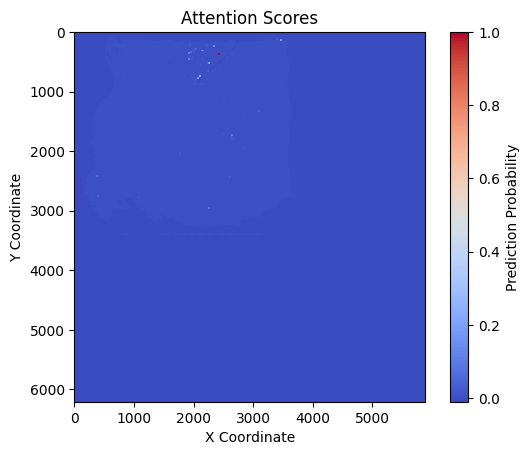

In [367]:
# %matplotlib inline
# # Map probabilities to the heatmap
# for att_coor in att_dict:
#     startx, endx, starty, endy  = att_coor['coords']
#     prob = att_coor['att']
    
#     heatmap[starty:endy+1, startx:endx+1] = prob

# # Plot the heatmap
# plt.imshow(heatmap, cmap='coolwarm', interpolation='nearest')
# plt.colorbar(label='Prediction Probability')
# plt.title('Attention Scores')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.show()